In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [3]:
spark

In [4]:
Bombing_Operations = spark.read.json("Bombing_Operations.json.gz")
Aircraft_Glossary = spark.read.json("Aircraft_Glossary.json.gz")

In [5]:
#print the schema
Bombing_Operations.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)



In [6]:
Aircraft_Glossary.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)



In [7]:
#take (the top) k entries out of the data-set
Bombing_Operations.take(3)

[Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1971-06-05', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='TAN SON NHUT', TargetCountry='CAMBODIA', TimeOnTarget=1005.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1972-12-26', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='NAKHON PHANOM', TargetCountry='SOUTH VIETNAM', TimeOnTarget=530.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='RF-4', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1973-07-28', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='UDORN AB', TargetCountry='LAOS', TimeOnTarget=730.0, WeaponType=None, WeaponsLoadedWeight=0)]

In [8]:
#get a formatted sample of the data
Aircraft_Glossary.show()

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

In [9]:
#print #total entries in the data-set
print("In total there are {0} operations".format(Bombing_Operations.count()))

In total there are 4400775 operations


# Question 1: Which countries are involved and in how many missions? 

In [10]:
#Method 1: Spark SQL
missions_counts = Bombing_Operations.groupBy("ContryFlyingMission")\
                                    .agg(count("*").alias("MissionsCount"))\
                                    .sort(desc("MissionsCount"))
missions_counts.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



In [11]:
#Method 2: Pure SQL
Bombing_Operations.registerTempTable("Bombing_Operations")

query = """
SELECT ContryFlyingMission, count(*) as MissionsCount
FROM Bombing_Operations
GROUP BY ContryFlyingMission
ORDER BY MissionsCount DESC
"""

missions_counts = spark.sql(query)
missions_counts.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



In [12]:
missions_count_pd = missions_counts.toPandas()

In [13]:
missions_count_pd

,ContryFlyingMission,MissionsCount
0,UNITED STATES OF AMERICA,3708997
1,VIETNAM (SOUTH),622013
2,LAOS,32777
3,KOREA (SOUTH),24469
4,AUSTRALIA,12519


Text(0.5, 1.0, 'Number of missions by Country')

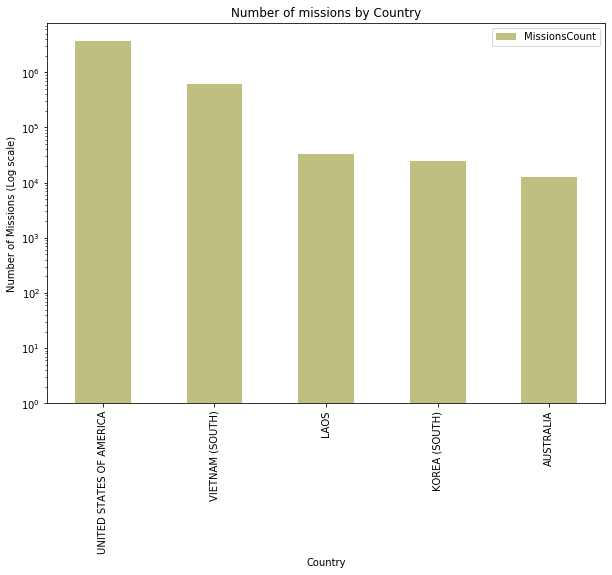

In [14]:
pl = missions_count_pd.plot(kind="bar", 
                            x="ContryFlyingMission", y="MissionsCount", 
                            figsize=(10, 7), log=True, alpha=0.5, color="olive")
pl.set_xlabel("Country")
pl.set_ylabel("Number of Missions (Log scale)")
pl.set_title("Number of missions by Country")

# Questions 2: Show the number of missions in time for each of the countries involved.

In [15]:
missions_countries = Bombing_Operations.selectExpr(["to_date(MissionDate) as MissionDate", "ContryFlyingMission"])

In [16]:
missions_by_date = missions_countries\
                    .groupBy(["MissionDate", "ContryFlyingMission"])\
                    .agg(count("*").alias("MissionsCount"))\
                    .sort(asc("MissionDate")).toPandas()
missions_by_date.head()

,MissionDate,ContryFlyingMission,MissionsCount
0,1965-10-01,UNITED STATES OF AMERICA,447
1,1965-10-02,UNITED STATES OF AMERICA,652
2,1965-10-03,UNITED STATES OF AMERICA,608
3,1965-10-04,UNITED STATES OF AMERICA,532
4,1965-10-05,UNITED STATES OF AMERICA,697


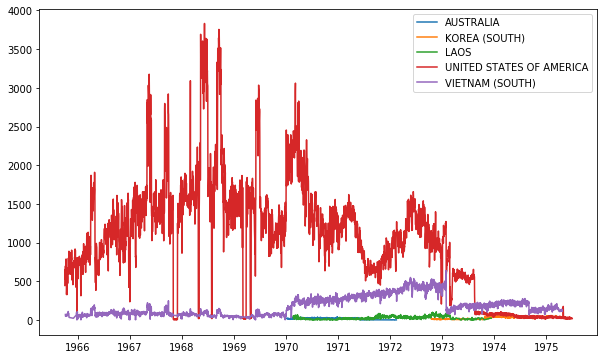

In [17]:
fig = plt.figure(figsize=(10, 6))

# iterate the different groups to create a different series
for country, missions in missions_by_date.groupby("ContryFlyingMission"): 
    plt.plot(missions["MissionDate"], missions["MissionsCount"], label=country)

plt.legend(loc='best')

# Question 3: Who bombed this location?

In [18]:
jun_29_operations = Bombing_Operations.where("MissionDate = '1966-06-29' AND TargetCountry='NORTH VIETNAM'")
jun_29_operations.count()

395

In [19]:
jun_29_operations.groupBy("ContryFlyingMission").agg(count("*").alias("MissionsCount")).toPandas()

,ContryFlyingMission,MissionsCount
0,VIETNAM (SOUTH),6
1,UNITED STATES OF AMERICA,389


In [20]:
jun_29_operations.cache()

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint]

In [21]:
%time jun_29_operations.count()

CPU times: user 1.7 ms, sys: 1.8 ms, total: 3.5 ms
Wall time: 9.95 s


395

In [22]:
%time jun_29_operations.count()

CPU times: user 546 µs, sys: 909 µs, total: 1.45 ms
Wall time: 56.3 ms


395

In [23]:
jun_29_operations.write.mode('overwrite').json("jun_29_operations.json")

In [24]:
jun_29_operations = spark.read.json("jun_29_operations.json")

In [25]:
TakeoffLocationCounts = jun_29_operations\
                            .groupBy("TakeoffLocation").agg(count("*").alias("MissionsCount"))\
                            .sort(desc("MissionsCount"))
TakeoffLocationCounts.show()

+----------------+-------------+
| TakeoffLocation|MissionsCount|
+----------------+-------------+
|   CONSTELLATION|           87|
|          TAKHLI|           56|
|           KORAT|           55|
|        UDORN AB|           44|
|         UBON AB|           44|
|          RANGER|           35|
|          DANANG|           35|
|    TAN SON NHUT|           26|
|HANCOCK (CVA-19)|           10|
|    CAM RANH BAY|            2|
|         CUBI PT|            1|
+----------------+-------------+



In [26]:
all_locations = jun_29_operations.rdd.map(lambda row: (row.TakeoffLocation, 1))
all_locations.take(3)

[('TAKHLI', 1), ('DANANG', 1), ('CONSTELLATION', 1)]

In [27]:
locations_counts_rdd = all_locations.reduceByKey(lambda a, b: a+b).sortBy(lambda r: -r[1])
locations_counts_rdd.take(3)

[('CONSTELLATION', 87), ('TAKHLI', 56), ('KORAT', 55)]

In [28]:
locations_counts_with_schema = locations_counts_rdd.map(lambda r: Row(TakeoffLocation=r[0], MissionsCount=r[1]))
locations_counts = spark.createDataFrame(locations_counts_with_schema)
locations_counts.show()

+----------------+-------------+
| TakeoffLocation|MissionsCount|
+----------------+-------------+
|   CONSTELLATION|           87|
|          TAKHLI|           56|
|           KORAT|           55|
|         UBON AB|           44|
|        UDORN AB|           44|
|          DANANG|           35|
|          RANGER|           35|
|    TAN SON NHUT|           26|
|HANCOCK (CVA-19)|           10|
|    CAM RANH BAY|            2|
|         CUBI PT|            1|
+----------------+-------------+



# Questions 4: What is the most used aircraft type during the Vietnam war (number of missions)?

In [29]:
Aircraft_Glossary.show(5)

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
+--------+--------------------+--------------------+
only showing top 5 rows



In [30]:
Bombing_Operations.select("AirCraft").show(5)

+--------+
|AirCraft|
+--------+
|   EC-47|
|   EC-47|
|    RF-4|
|     A-1|
|    A-37|
+--------+
only showing top 5 rows



In [31]:
missions_joined = Bombing_Operations.join(Aircraft_Glossary, 
                                          Bombing_Operations.AirCraft == Aircraft_Glossary.AirCraft)
missions_joined

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint, AirCraft: string, AirCraftName: string, AirCraftType: string]

In [32]:
missions_aircrafts = missions_joined.select("AirCraftType")
missions_aircrafts.show(5)

+--------------------+
|        AirCraftType|
+--------------------+
|Military Transpor...|
|Military Transpor...|
|  Fighter bomber jet|
|         Fighter Jet|
|Light ground-atta...|
+--------------------+
only showing top 5 rows



In [33]:
missions_aircrafts.groupBy("AirCraftType").agg(count("*").alias("MissionsCount"))\
                  .sort(desc("MissionsCount"))\
                  .show()

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows



In [34]:
Bombing_Operations.registerTempTable("Bombing_Operations")
Aircraft_Glossary.registerTempTable("Aircraft_Glossary")

query = """
SELECT AirCraftType, count(*) MissionsCount
FROM Bombing_Operations bo
JOIN Aircraft_Glossary ag
ON bo.AirCraft = ag.AirCraft
GROUP BY AirCraftType
ORDER BY MissionsCount DESC
"""

spark.sql(query).show()

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows

